# Lets try to forecast the demand of each product

In [6]:
import pandas as pd
df = pd.read_csv("online_retail_II.csv")
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
1067366,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
1067367,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
1067368,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
1067369,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


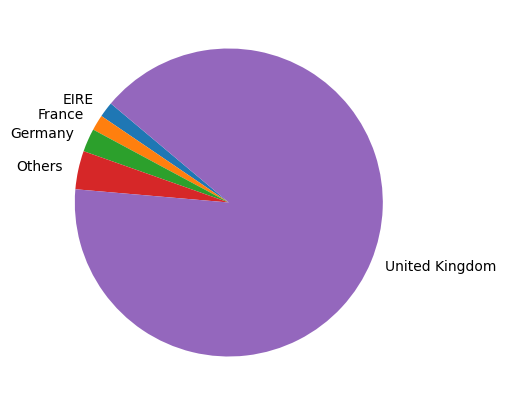

In [7]:
df_unique_clients = df.drop_duplicates(subset='Invoice',inplace=False)
clients_per_country = df_unique_clients.groupby('Country').count().sort_values(by='Customer ID', ascending=False)['Customer ID']


#pie plotting
min_clients_to_appear = clients_per_country.sum()/100
clients_per_country_for_barplot=clients_per_country.copy()
clients_per_country_for_barplot.index = [
    idx if value > min_clients_to_appear else 'Others'
    for idx, value in clients_per_country.items()
]
clients_per_country_for_barplot = clients_per_country_for_barplot.groupby(level=0).sum()#sum is made to really group the other coutries clients
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.pie(clients_per_country_for_barplot, labels=clients_per_country_for_barplot.index, startangle=140)
plt.show()

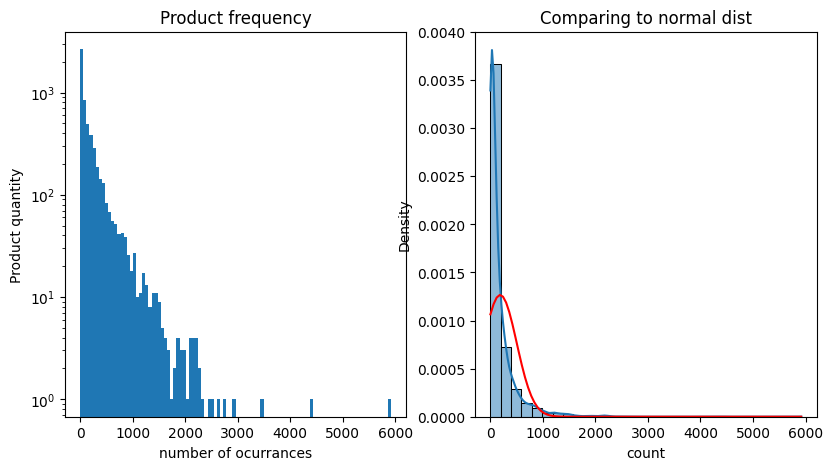

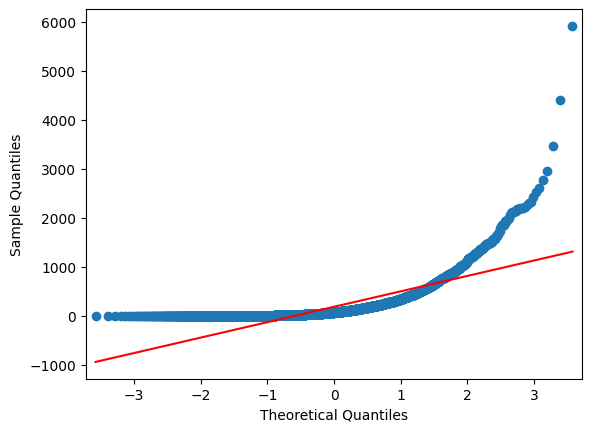

5698

In [8]:
import seaborn as sns
from scipy.stats import norm
import numpy as np

product_counts = df['Description'].value_counts()
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(product_counts, bins=100, log=True)# escala log 
plt.xlabel('number of ocurrances')
plt.ylabel('Product quantity')
plt.title('Product frequency')

plt.subplot(1, 3, 2)
sns.histplot(product_counts, kde=True, stat='density', bins=30)
x = np.linspace(min(product_counts), max(product_counts), 100)
plt.plot(
    x,
    norm.pdf(x, np.mean(product_counts), np.std(product_counts)),
    color='red'
)
plt.title('Comparing to normal dist')

from statsmodels.graphics.gofplots import qqplot
plt.subplot(1, 3, 2)
qqplot(product_counts, line='s')
plt.show()

len(product_counts)


As expected, the product frequency distribution is not normal, lets see how can we remove the outlyers, i will use MAD algorithm since this one is more useful for our type of distribution

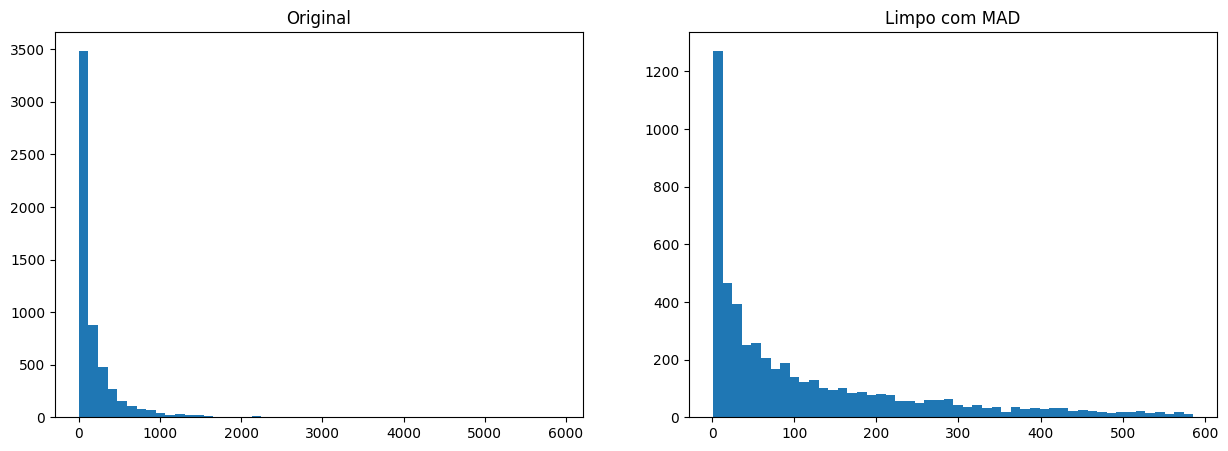

qtd_compras=53628
qtd_produtos=5698
porcentagem de outlyers 8.4
porcentagem de outlyers inferiores 4.2
porcentagem de outlyers superiores 4.2


In [9]:
from scipy.stats import median_abs_deviation

def remove_exponential_outliers(series, mad_thresh=3.5):
    median = series.median()
    mad = median_abs_deviation(series, scale='normal')
    modified_z = 0.6745 * (series - median) / mad
    clean_data = series[~(modified_z.abs() >= mad_thresh)]
    outlyers = series[(modified_z.abs() >= mad_thresh)]
    return clean_data, outlyers


product_counts_clean,product_counts_outlyers = remove_exponential_outliers(product_counts)

# Compare visualmente
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(product_counts, bins=50)
plt.title('Original')
plt.subplot(1, 2, 2)
plt.hist(product_counts_clean, bins=50)
plt.title('Limpo com MAD')
plt.show()
print("qtd_compras="+str(len(df['Invoice'].value_counts())))
print("qtd_produtos="+str(len(product_counts)))
print("porcentagem de outlyers "+str(round(100*len(product_counts_outlyers)/len(product_counts_clean),1)))
print("porcentagem de outlyers inferiores "+str(round(100*len(product_counts_outlyers[product_counts_outlyers.median()<product_counts_outlyers])/len(product_counts_clean),1)))
print("porcentagem de outlyers superiores "+str(round(100*len(product_counts_outlyers[product_counts_outlyers.median()>product_counts_outlyers])/len(product_counts_clean),1)))


In [10]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [11]:
#making sure there are no repeats of products, even if the price changes (may be a different product)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
group_cols = [col for col in df.columns if col not in ['Quantity','StockCode','Price', 'InvoiceDate']]
print(group_cols)
df_grouped_item_names = df.groupby(group_cols, as_index=False).agg({'Quantity': 'sum', 'InvoiceDate': 'min'})
print(str(len(df_grouped_item_names)))


['Invoice', 'Description', 'Customer ID', 'Country']
786881


In [12]:
# Find repeating items in the same InvoiceDate
repeats = df_grouped_item_names.groupby(['Invoice', 'Description']).size().reset_index(name='count')
repeats = repeats[repeats['count'] > 1]
print(repeats)

Empty DataFrame
Columns: [Invoice, Description, count]
Index: []


### Now we will clusterize the products to facilitate each type of product demand forecasting

In [13]:
basket = df_grouped_item_names.groupby(['Invoice', 'Description']).size().unstack(fill_value=0)
basket = basket > 0

In [14]:
from mlxtend.frequent_patterns import fpgrowth, association_rules

MIN_lift = 0.7
MIN_leverage = 0.01

#Using fp-growth
frequent_itemsets = fpgrowth(basket, min_support=0.01, use_colnames=True)
# getting the asociation rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
#selecting only good realtionships
rules = rules[(rules['lift']>MIN_lift)|(rules['leverage']>MIN_leverage)]
rules['lift x leverage']=rules['lift']*rules['leverage']

In [15]:
import networkx as nx
from networkx.algorithms.community import k_clique_communities

# create the 
G = nx.Graph()
for _, row in rules.iterrows():
    for a in row['antecedents']:
        for c in row['consequents']:
            if G.has_edge(a, c):
                G[a][c]['weight'] += row['lift x leverage']
            else:
                G.add_edge(a, c, weight=row['lift x leverage'])

#create the cluster
k = 2 #at least a relation of 3 products for a communitie
communities = list(k_clique_communities(G, k))
overlapping_clusters = [set(comm) for comm in communities]

for i, c in enumerate(overlapping_clusters):
    print(f"Cluster {i}: {c}")

Cluster 0: {'JUMBO SHOPPER VINTAGE RED PAISLEY', 'LUNCH BAG PINK POLKADOT', 'LUNCH BAG RED RETROSPOT', 'JUMBO BAG PINK VINTAGE PAISLEY', 'JUMBO  BAG BAROQUE BLACK WHITE', 'LUNCH BAG SUKI DESIGN ', 'LUNCH BAG  BLACK SKULL.', 'LUNCH BAG DOLLY GIRL DESIGN', 'JUMBO BAG RED RETROSPOT', 'LUNCH BAG WOODLAND', 'LUNCH BAG SPACEBOY DESIGN ', 'LUNCH BAG SUKI  DESIGN ', 'JUMBO BAG STRAWBERRY', 'JUMBO STORAGE BAG SKULLS', 'JUMBO STORAGE BAG SUKI', 'JUMBO BAG PINK POLKADOT', 'LUNCH BAG CARS BLUE'}
Cluster 1: {'WOODEN STAR CHRISTMAS SCANDINAVIAN', 'WOODEN HEART CHRISTMAS SCANDINAVIAN'}
Cluster 2: {'DOLLY GIRL LUNCH BOX', 'SPACEBOY LUNCH BOX '}
Cluster 3: {'SINGLE HEART ZINC T-LIGHT HOLDER', 'HANGING HEART ZINC T-LIGHT HOLDER'}
Cluster 4: {'PACK OF 60 DINOSAUR CAKE CASES', 'PACK OF 72 RETRO SPOT CAKE CASES', '60 TEATIME FAIRY CAKE CASES', 'PACK OF 72 SKULL CAKE CASES', 'PACK OF 60 PINK PAISLEY CAKE CASES', '72 SWEETHEART FAIRY CAKE CASES'}
Cluster 5: {'COOK WITH WINE METAL SIGN ', 'GIN + TONIC DIET ME

Computing the sells of each community, day by day

In [16]:
df_grouped_item_names.columns

Index(['Invoice', 'Description', 'Customer ID', 'Country', 'Quantity',
       'InvoiceDate'],
      dtype='object')

In [17]:
df_grouped_item_names['InvoiceDate'] = df_grouped_item_names['InvoiceDate'].dt.normalize()

min_date = df_grouped_item_names['InvoiceDate'].min()
max_date = df_grouped_item_names['InvoiceDate'].max()
date_range = pd.date_range(start=min_date, end=max_date, freq='W')

product_sales = pd.DataFrame(columns=['Description'] + list(date_range))
cluster_sales_as_dict={}
for c in overlapping_clusters:
    for p in c:
        if(len(product_sales[product_sales['Description']==str(p)])!=0):
            continue
        row = {'Description': p}
        p_appearences = df_grouped_item_names[df_grouped_item_names['Description']==str(p)]
        for i, date in enumerate(date_range):
            if(i==(len(date_range)-1)):
                row[date] = p_appearences[p_appearences['InvoiceDate']>date]['Quantity'].sum()
            else:
                row[date] = p_appearences[(p_appearences['InvoiceDate']>date) & (p_appearences['InvoiceDate']<date_range[i+1])]['Quantity'].sum()
        product_sales = pd.concat([product_sales, pd.DataFrame([row])], ignore_index=True)


exclude_cols = ['Description']
date_cols = [col for col in product_sales.columns if col not in exclude_cols]
total_product_sales = product_sales[date_cols].sum(axis=1)
#normalyzing so we have no problem when summing it with others for the cluster seasonality analisys
product_sales[date_cols] = product_sales[date_cols].div(total_product_sales, axis=0)
product_sales.head()



,Description,2009-12-06 00:00:00,2009-12-13 00:00:00,2009-12-20 00:00:00,2009-12-27 00:00:00,2010-01-03 00:00:00,2010-01-10 00:00:00,2010-01-17 00:00:00,2010-01-24 00:00:00,2010-01-31 00:00:00,...,2011-10-02 00:00:00,2011-10-09 00:00:00,2011-10-16 00:00:00,2011-10-23 00:00:00,2011-10-30 00:00:00,2011-11-06 00:00:00,2011-11-13 00:00:00,2011-11-20 00:00:00,2011-11-27 00:00:00,2011-12-04 00:00:00
0,JUMBO SHOPPER VINTAGE RED PAISLEY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005022,0.009953,...,0.002511,0.00977,0.002146,0.004337,0.001141,0.020636,0.010729,0.01356,0.013514,0.011734
1,LUNCH BAG PINK POLKADOT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005582,0.006169,0.007834,0.009499,0.014787,0.011457,0.020564,0.011849,0.013514,0.008128
2,LUNCH BAG RED RETROSPOT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011734,0.020508,0.01195,0.012003,0.010119,0.02067,0.028421,0.010066,0.013457,0.013672
3,JUMBO BAG PINK VINTAGE PAISLEY,0.011731,0.011327,0.000944,0.0,0.01735,0.019373,0.001169,0.013754,0.002922,...,0.016541,0.002832,0.003236,0.002697,0.001663,0.01726,0.003416,0.001528,0.004,0.007192
4,JUMBO BAG BAROQUE BLACK WHITE,0.02646,0.005595,0.001088,0.0,0.00272,0.015076,0.003419,0.008159,0.009247,...,0.0061,0.006566,0.006605,0.013249,0.00136,0.008121,0.019622,0.006994,0.01457,0.00474


In [18]:
print(min_date)
print(max_date)

2009-12-01 00:00:00
2011-12-09 00:00:00


In [19]:
cluster_sales = pd.DataFrame(columns=['Cluster_id'] + list(date_range))
for i, c in enumerate(overlapping_clusters):
    row = {'Cluster_id':i}
    cluster_products = product_sales[product_sales['Description'].map(lambda x: x in c)]
    
    for date in date_range:
        row[date] = cluster_products[date].sum()
    cluster_sales = pd.concat([cluster_sales, pd.DataFrame([row])], ignore_index=True)

not_month_cols = ['Cluster_id','MonthlySalesMean','MonthlySalesStddev']
date_cols = [c for c in cluster_sales.columns if c not in not_month_cols]
cluster_sales['MonthlySalesMean'] = cluster_sales[date_cols].mean(axis=1)
cluster_sales['MonthlySalesStddev'] = cluster_sales[date_cols].std(axis=1)
cluster_sales.head()


/tmp/ipykernel_50641/2185230957.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cluster_sales = pd.concat([cluster_sales, pd.DataFrame([row])], ignore_index=True)


,Cluster_id,2009-12-06 00:00:00,2009-12-13 00:00:00,2009-12-20 00:00:00,2009-12-27 00:00:00,2010-01-03 00:00:00,2010-01-10 00:00:00,2010-01-17 00:00:00,2010-01-24 00:00:00,2010-01-31 00:00:00,...,2011-10-16 00:00:00,2011-10-23 00:00:00,2011-10-30 00:00:00,2011-11-06 00:00:00,2011-11-13 00:00:00,2011-11-20 00:00:00,2011-11-27 00:00:00,2011-12-04 00:00:00,MonthlySalesMean,MonthlySalesStddev
0,0,0.076913,0.094660,0.009928,0.0,0.097094,0.065677,0.057110,0.076057,0.067217,...,0.132339,0.134402,0.113982,0.214387,0.236123,0.180824,0.174786,0.112917,0.161905,0.078198
1,1,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.137882,0.104580,0.116839,0.196751,0.168461,0.229470,0.141663,0.084949,0.019048,0.044031
2,2,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.031725,0.027834,0.017385,0.030697,0.029172,0.033194,0.011730,0.024788,0.019048,0.020070
3,3,0.023372,0.031698,0.000129,0.0,0.006509,0.009606,0.048163,0.026905,0.013799,...,0.008374,0.002239,0.010095,0.004141,0.003839,0.010732,0.021388,0.011830,0.019048,0.013514
4,4,0.051394,0.071802,0.073240,0.0,0.070462,0.049866,0.120857,0.113222,0.042049,...,0.037385,0.034065,0.016467,0.017806,0.039977,0.026932,0.021709,0.016567,0.057143,0.038596


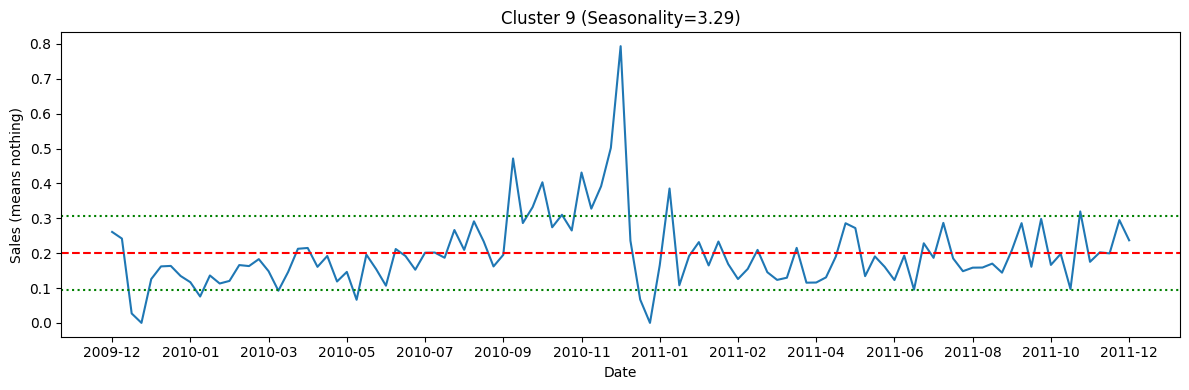

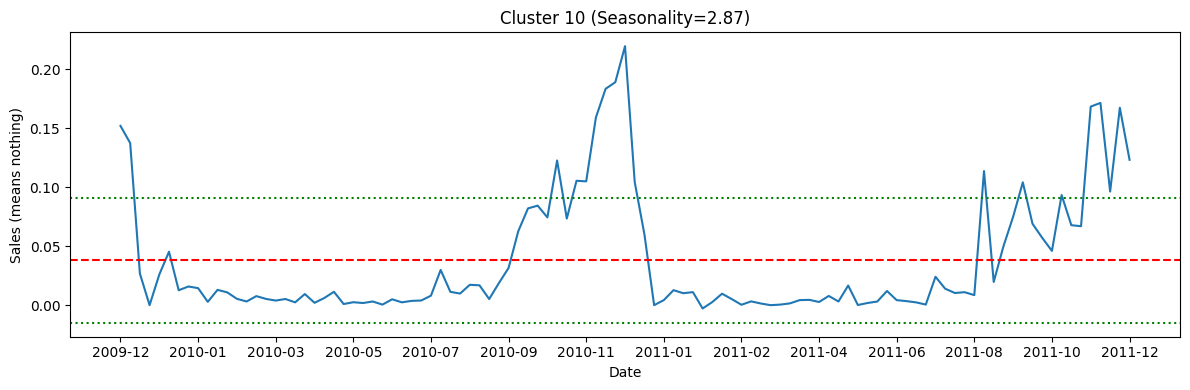

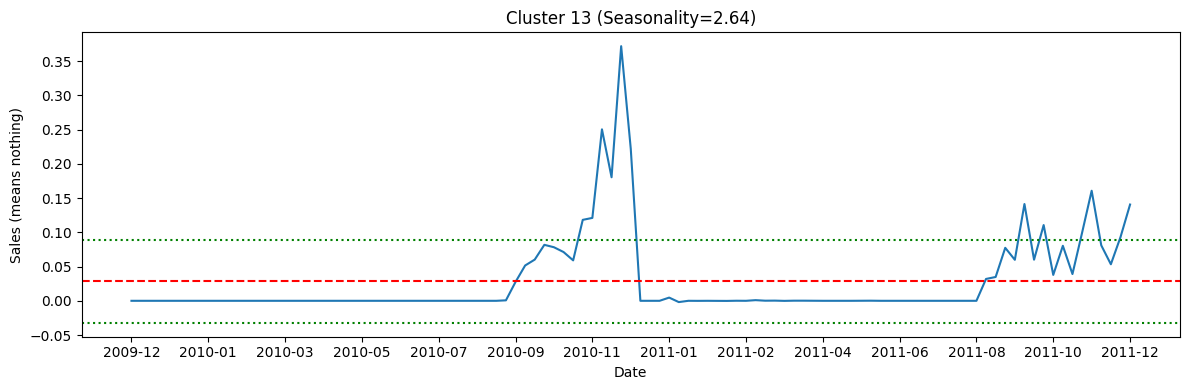

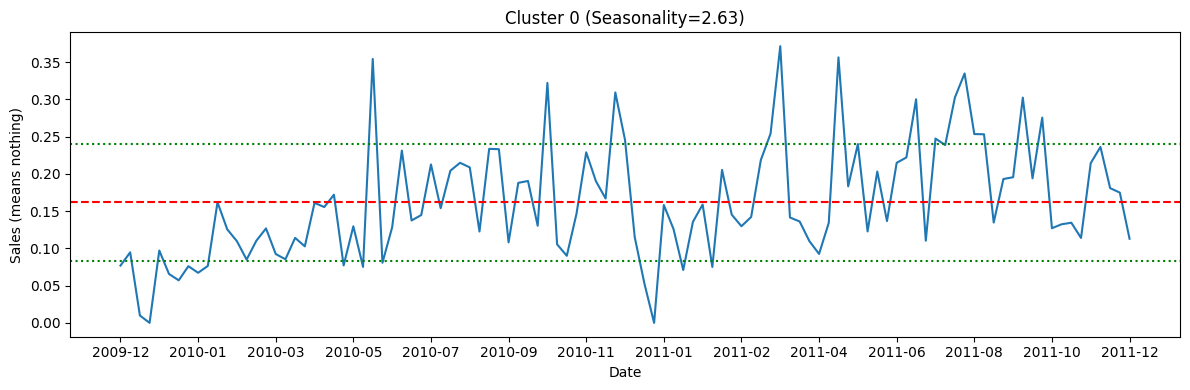

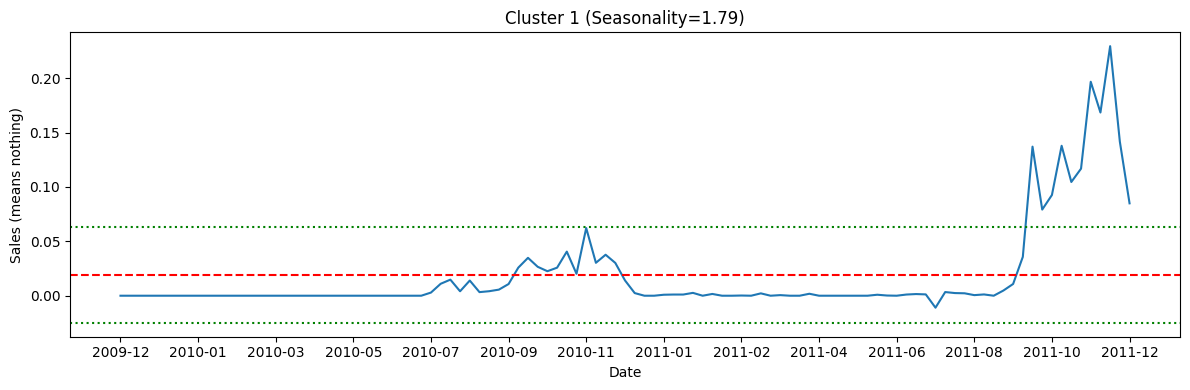

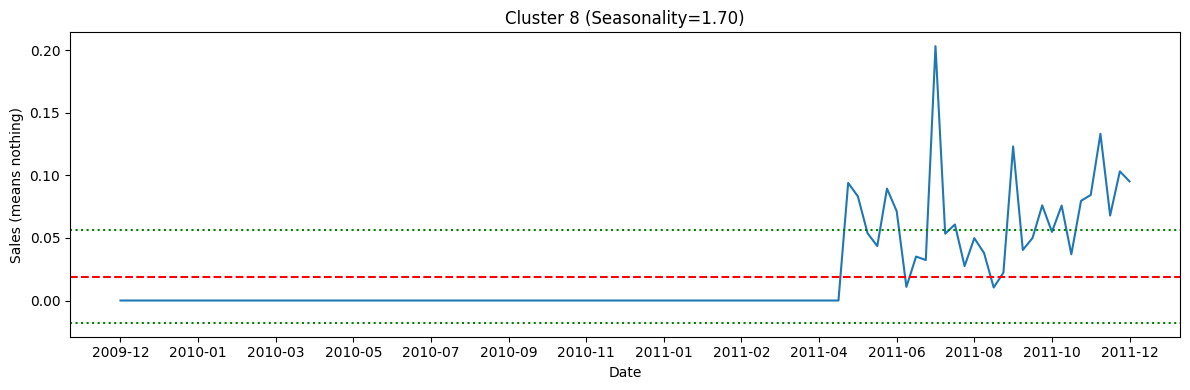

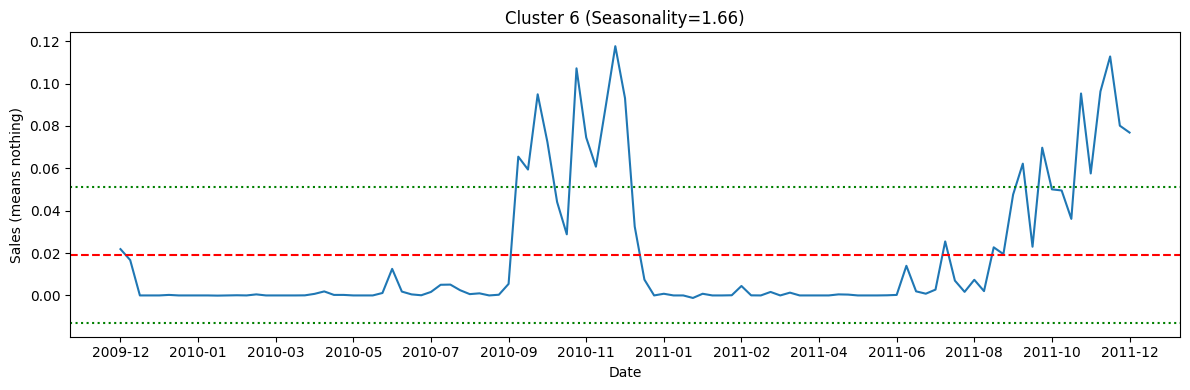

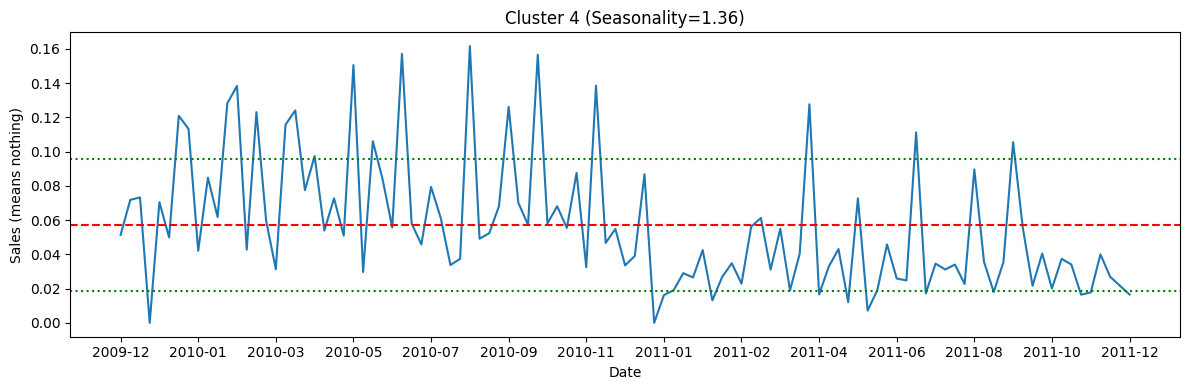

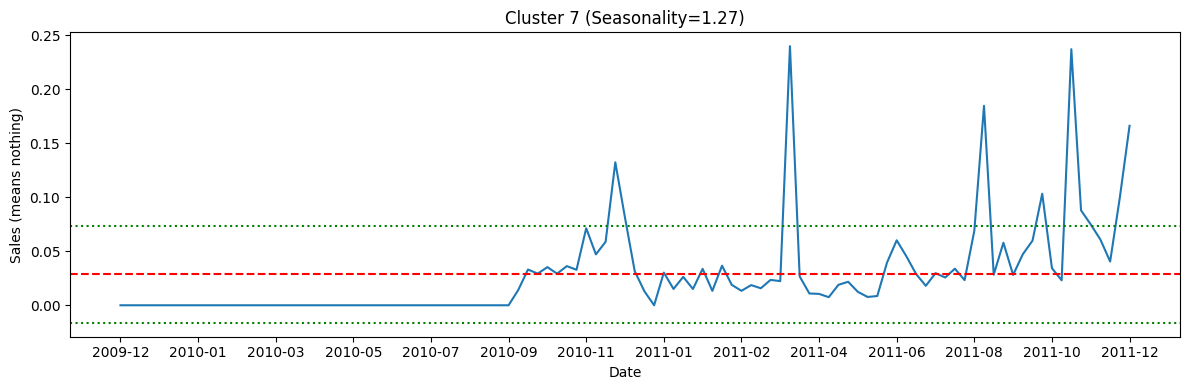

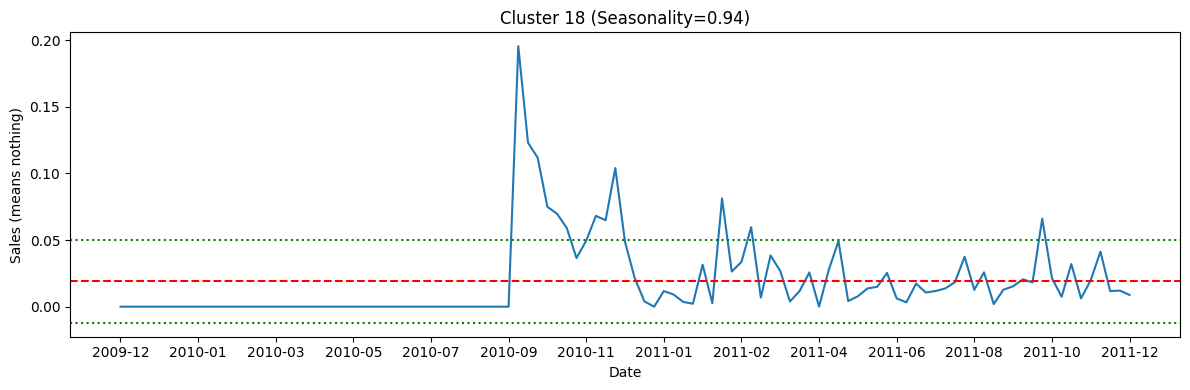

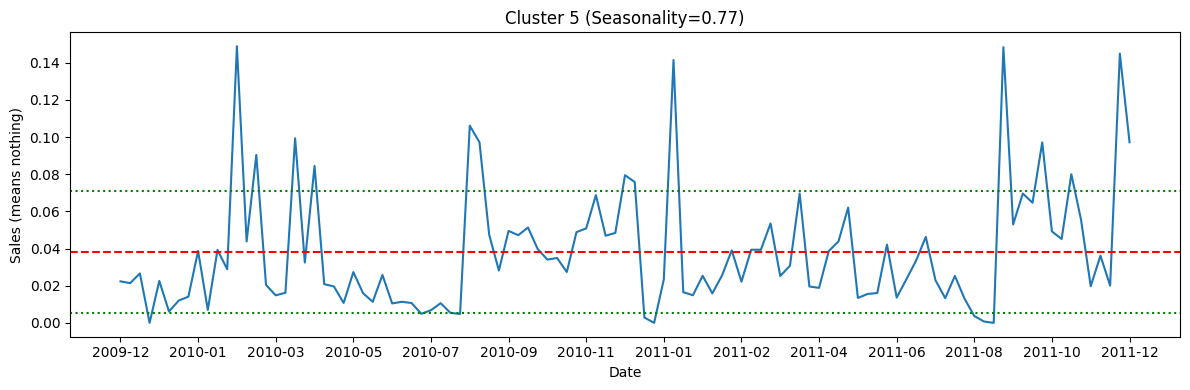

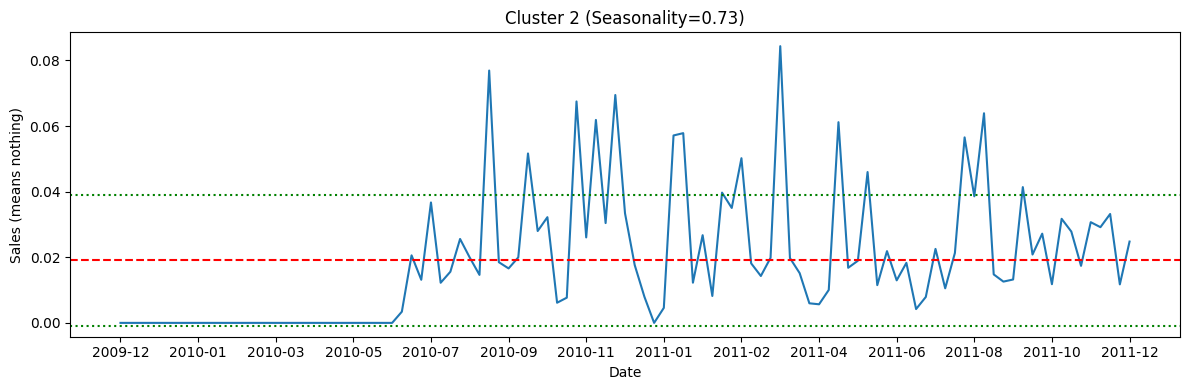

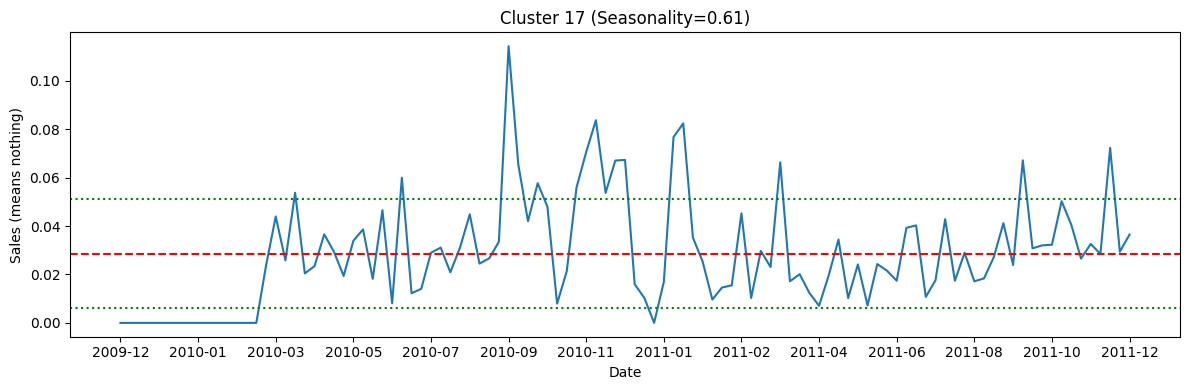

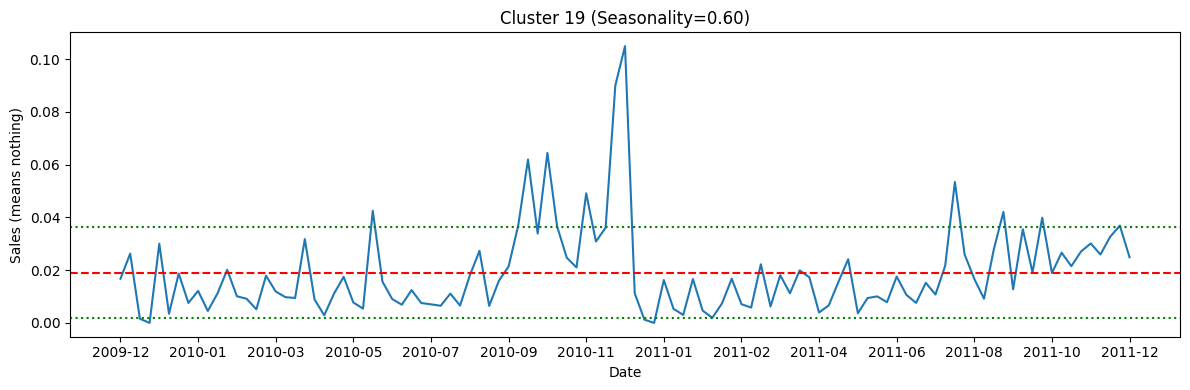

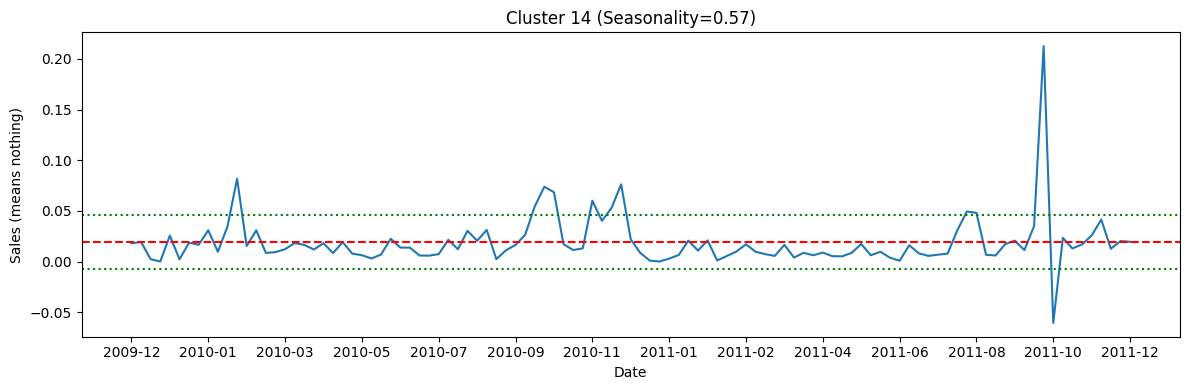

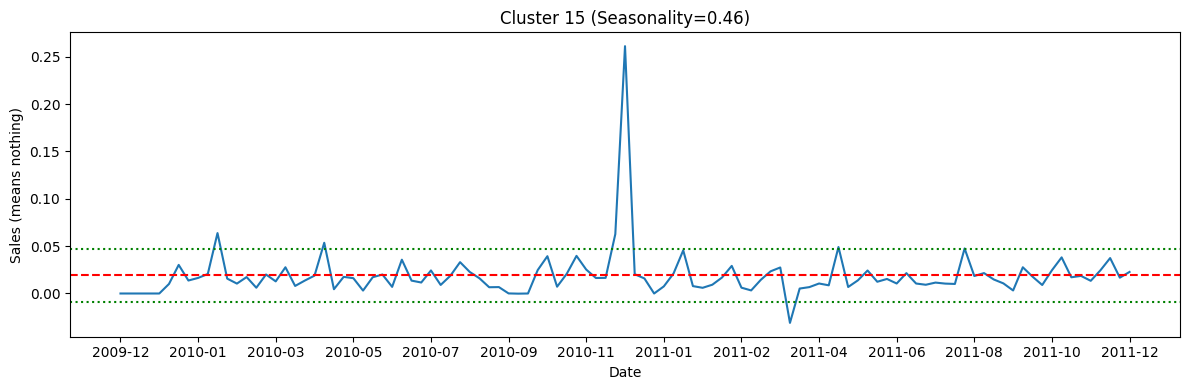

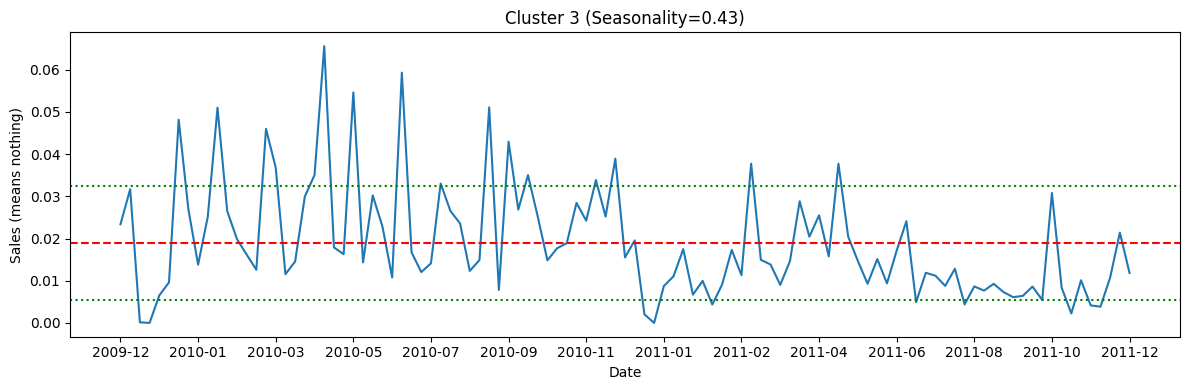

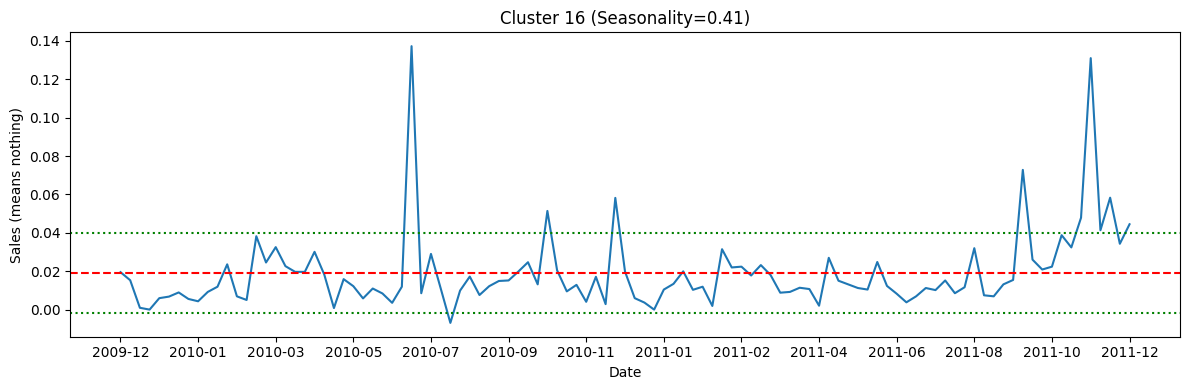

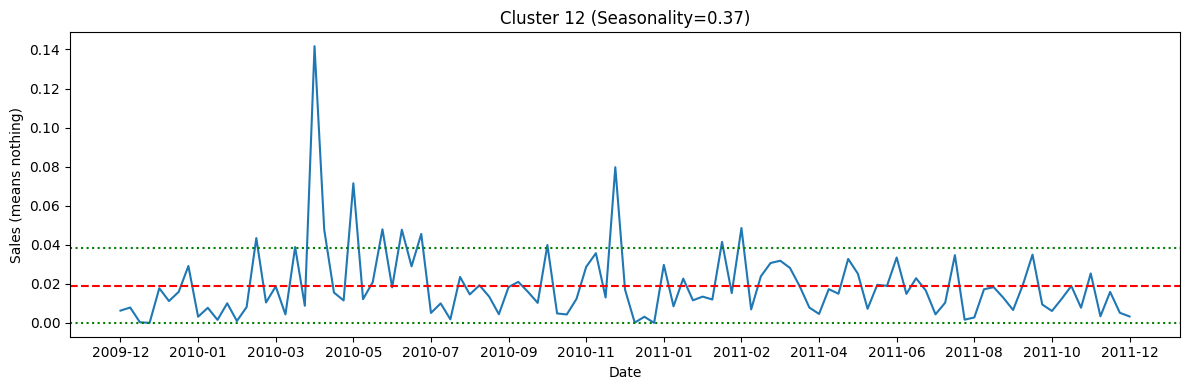

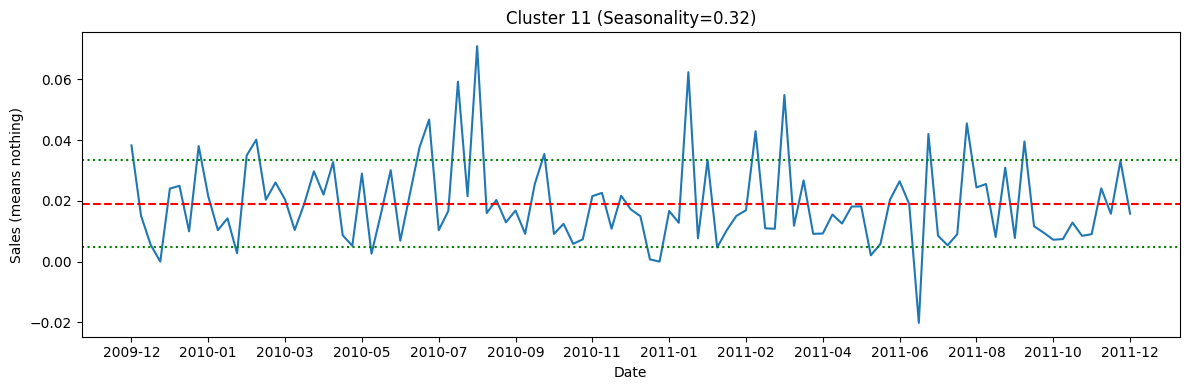

In [20]:
import numpy as np
from matplotlib.dates import DateFormatter

seasonality_strengths = []

for i, row in cluster_sales.iterrows():
    sales = row[date_cols].values.astype(float)
    fft = np.fft.fft(sales - np.mean(sales))
    fft_power = np.abs(fft)
    # Ignore the zero-frequency (trend) component
    seasonal_power = fft_power[1:len(fft_power)//2].max()
    seasonality_strengths.append((i, seasonal_power))

# Sort clusters by seasonality strength (descending)
seasonality_strengths.sort(key=lambda x: x[1], reverse=True)

for idx, strength in seasonality_strengths:
    row = cluster_sales.loc[idx]
    plt.figure(figsize=(12, 4))
    plt.plot(date_cols, cluster_sales.loc[idx, date_cols])
    mean_sales = plt.axhline(row['MonthlySalesMean'], color='red', linestyle='--', label='Mean')
    lower_std_limit = plt.axhline(row['MonthlySalesMean'] + row['MonthlySalesStddev'], color='green', linestyle=':', label='+1 Stddev')
    upper_std_limit = plt.axhline(row['MonthlySalesMean'] - row['MonthlySalesStddev'], color='green', linestyle=':', label='-1 Stddev')
    plt.title(f"Cluster {int(cluster_sales.loc[idx, 'Cluster_id'])} (Seasonality={strength:.2f})")
    plt.xlabel('Date')
    plt.ylabel('Sales (means nothing)')
    plt.xticks(date_cols[::8])
    ax = plt.gca()
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_50641/2136403921.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ts_daily['Sales'] = ts_daily.join(ts).ffill()
15:24:28 - cmdstanpy - INFO - Chain [1] start processing
15:24:28 - cmdstanpy - INFO - Chain [1] done processing


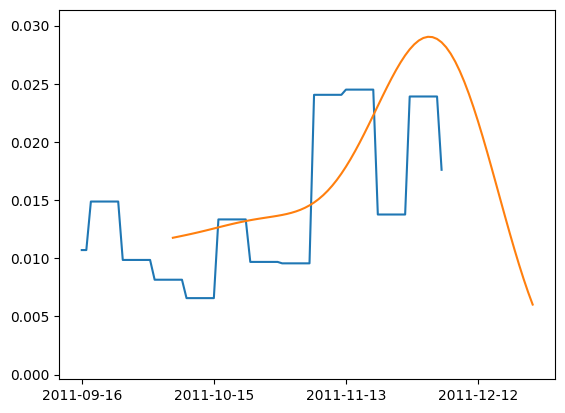

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Boxing Day,Boxing Day_lower,Boxing Day_upper,Boxing Day (observed),Boxing Day (observed)_lower,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2009-12-06,0.005605,0.024506,0.030180,0.005605,0.005605,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.021653,0.021653,0.021653,0.0,0.0,0.0,0.027258
2009-12-07,0.005605,0.023710,0.029369,0.005605,0.005605,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.020904,0.020904,0.020904,0.0,0.0,0.0,0.026508
2009-12-08,0.005605,0.022925,0.028729,0.005605,0.005605,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.020033,0.020033,0.020033,0.0,0.0,0.0,0.025638
2009-12-09,0.005605,0.021830,0.027440,0.005605,0.005605,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.019049,0.019049,0.019049,0.0,0.0,0.0,0.024654
2009-12-10,0.005605,0.020780,0.026469,0.005605,0.005605,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.017963,0.017963,0.017963,0.0,0.0,0.0,0.023568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-20,0.005605,0.007833,0.013627,0.005605,0.005605,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.005155,0.005155,0.005155,0.0,0.0,0.0,0.010759
2011-12-21,0.005605,0.006551,0.012475,0.005605,0.005605,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.003858,0.003858,0.003858,0.0,0.0,0.0,0.009463
2011-12-22,0.005605,0.005378,0.011027,0.005605,0.005605,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.002628,0.002628,0.002628,0.0,0.0,0.0,0.008233


In [ ]:
from prophet import Prophet

#data prep
ts = cluster_sales.T
ts.columns = [f'Cluster {i}' for i in ts.columns]
ts.index.name = 'Date'
ts = ts[ts.index != 'Cluster_id']
ts = ts[ts.index != 'MonthlySalesMean']
ts = ts[ts.index != 'MonthlySalesStddev']
ts = ts['Cluster 10']


ts_daily = pd.date_range(start=ts.index.min(),
                            end=ts.index.max(),
                            freq='D')
ts_daily = pd.DataFrame(index=ts_daily)
ts_daily.index.name='Date'
ts_daily['Sales'] = ts_daily.join(ts).ffill()
ts_daily['Sales'] = ts_daily['Sales'] / 7
ts_daily=ts_daily['Sales']
ts_daily_new = pd.DataFrame(columns=['ds','y'])
ts_daily_new['ds']= ts_daily.index
ts_daily_new['y']= ts_daily.values

ts_daily=ts_daily_new

prediction_period=60
cut_idx = int(len(ts_daily)-prediction_period)#prever um mes
ts_daily_train = ts_daily[:cut_idx]
ts_daily_test = ts_daily[cut_idx:]


modelo = Prophet(
    growth='flat',      
    yearly_seasonality=True,
    weekly_seasonality=False, 
    daily_seasonality=False
)

modelo.add_seasonality('yearly', period=(365.25), fourier_order=6)
modelo.add_country_holidays(country_name='UK')

modelo.fit(ts_daily_train)
forecast = modelo.predict(modelo.make_future_dataframe(periods=int(prediction_period*4/3),freq='D'))
forecast.set_index('ds',inplace=True)
ts_daily.set_index('ds',inplace=True)

plt.yticks((ts_daily['y'].min(), ts_daily['y'].max()))
plt.plot(ts_daily['y'].tail(int(prediction_period*4/3)))
plt.plot(forecast['yhat'].tail(int(prediction_period*4/3)))
plt.xticks(forecast.tail(int(prediction_period*5/3)).index[::29])
plt.show()
forecast